# Importing Dependencies

In [1]:
# Data Wrangling
import os
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Model Preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from collections import Counter

# Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model Evaluation
from sklearn.metrics import classification_report,confusion_matrix

# Importing Images

In [2]:
# Initialize the image directory
image_dir = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [3]:
# Loop through each image in folder and put it to a DataFrame
label = []
path = []

for dir_name, _, filenames in os.walk(image_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == ".png":
            if dir_name.split()[-1]!="GT":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({"path": path, "label": label})

# EDA

In [4]:
# Distribution among our labels
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [5]:
# What does a full length path look like?
print(data["path"].iloc[0])

/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png


In [6]:
# Data exploration, Image Visualization
def get_images_from_folder(directory):
    images = []
    labels = []
    for dir_name, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if os.path.splitext(filename)[-1] == ".png":
                if dir_name.split()[-1]!="GT":
                    
                    img_path = os.path.join(dir_name, filename)
                    image = load_img(img_path)                      # load_img is the essential method here
                    images.append(image)

                    # label extraction is done here
                    labels.append(os.path.split(dir_name)[-1])
                   

    return images, labels

data_images, data_labels = get_images_from_folder("/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset")

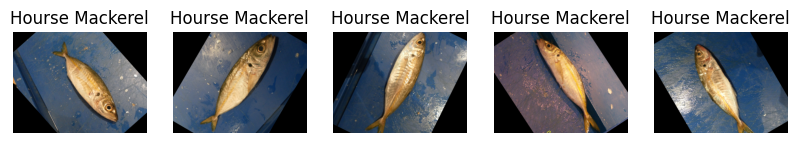

In [7]:
# See stock images from the dataset
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

display_images(data_images, data_labels)

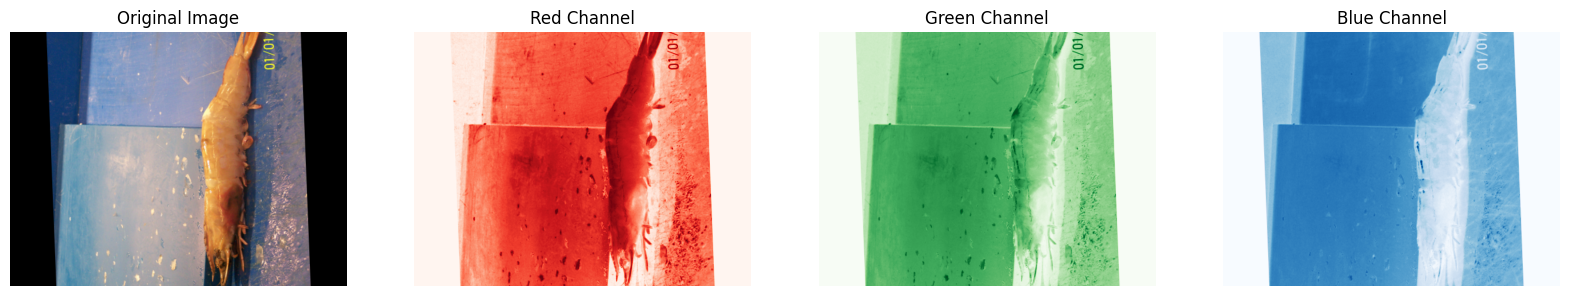

In [8]:
# Load an image using OpenCV
img = cv2.imread('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00001.png')

# Convert the image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(img_rgb)

# Plotting the original and the R, G, B channels
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original Image
axes[0].imshow(img_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Red Channel
axes[1].imshow(R, cmap='Reds')
axes[1].set_title('Red Channel')
axes[1].axis('off')

# Green Channel
axes[2].imshow(G, cmap='Greens')
axes[2].set_title('Green Channel')
axes[2].axis('off')

# Blue Channel
axes[3].imshow(B, cmap='Blues')
axes[3].set_title('Blue Channel')
axes[3].axis('off')

plt.show()

Analysis: Blue background isn't optimal for one of our channels

## Analysing Image Dimensions

In [9]:
# Get only the first two shape of the images
def analyze_image_shapes(directory):
    shapes = []

    # Loop through all images in the directory
    for dir_name, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if os.path.splitext(filename)[-1] == ".png":
                if dir_name.split()[-1]!="GT":
                    img_path = os.path.join(dir_name, filename)
                    img = cv2.imread(img_path)

                    if img is not None: # If image exists
                        shapes.append(img.shape[:2])

    return shapes

# Load and analyze image shapes
image_shapes = analyze_image_shapes('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [10]:
# Convert shapes to a NumPy array 
image_shapes_np = np.array(image_shapes)

# Calculate median shape
median_shape = np.median(image_shapes_np, axis=0)

# Calculate mode shape
shape_counter = Counter([tuple(shape) for shape in image_shapes])
mode_shape = shape_counter.most_common(1)[0][0]

# Which shapes are the most common?
shape_counter.most_common(5)

[((445, 590), 9000)]

In [11]:
print(f"Median shape: {median_shape}")
print(f"Mode shape: {mode_shape}")

Median shape: [445. 590.]
Mode shape: (445, 590)


### Analysis Conclusion
We already knew from the dataset documentation that images were all the same size but this systematic double-checking doesn't hurt.

# Train Test Split

We will divide our dataset into Train, Test and Validation sets.

Startify will make sure each set has equal or close to equal distribution of our labels

In [12]:
labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

# Get label for Validation set
label_test_val = X_temp['label']

# Creating Validation from out X_temp
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

# Check the shapes of our sets
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (7200, 2)
The shape of test data (900, 2)
The shape of validation data (900, 2)


## Features and Targets

In [13]:
# Image parameters
image_size = 128
image_channel = 3
bat_size = 32

In [14]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255)

""" 

We didn't apply any additional Data Augmentation since our initial number of
images was 50 and was augmented to 1000.

"""

" \n\nWe didn't apply any additional Data Augmentation since our initial number of\nimages was 50 and was augmented to 1000.\n\n"

In [15]:
# Configure our generators for each set individually
# Shuffle is only True in our Train set!

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = image_dir,
                                                    x_col= "path",
                                                    y_col= "label",
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size),
                                                    class_mode="categorical"
                                                   )
val_generator = train_datagen.flow_from_dataframe(X_val, 
                                                 directory = image_dir,
                                                 x_col= "path",
                                                 y_col= "label",
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False,
                                                 class_mode="categorical"
                                                )

test_generator = train_datagen.flow_from_dataframe(X_test, 
                                                  directory = image_dir,
                                                  x_col= "path",
                                                  y_col= "label",
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False,
                                                  class_mode="categorical"
                                                 )

Found 7200 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [16]:
# Get number of classes
num_classes = len(train_generator.class_indices)

In [17]:
# Initialize our Model
model = Sequential()

 Hidden Layer
- Dropout will help us reduce over-fitting, we applied it over our hidden layers
- Batch Normalization will objectively improve our model's accuracy. It reduces over-fitting and will improve our model's train time since it trains multiple layers simultaneously and each weight is less dependent on other weights.
- We started with 512 neurons and reduced it by half after each hidden layer

 Output Layer
- The number of output neurons is equal to out number of classes
- Our activation function will be softmax since it needs to calculate the probability our each class and pick the highest probability

In [18]:
# Input Layer
model.add(tf.keras.layers.Input(shape=(image_size , image_size , 3)))
model.add(tf.keras.layers.Flatten())

#Hidden Layer 1
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

#Hidden Layer 2
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

#Hidden Layer 3
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

# Output layer
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) # Softmax function for multi-class classification 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,335,305 (96.65 MB)

 Trainable params: 25,333,513 (96.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [19]:
!pip install visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.1 MB/s eta 0:00:00


### Model Visualisation

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


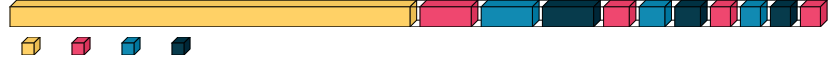

In [20]:
from visualkeras import layered_view

layered_view(model, legend=True, legend_text_spacing_offset=20, max_xy=400)

## Learning Rate Reduction

This technique will help us take smaller or bigger steps to learn in the direction where our loss function is minimized. It will adjust learning rate (alpha) based on the monitor value we will keep in check, in this case it will be our validation accuracy score.

Later it will wait two epochs for this score to improve, if it doesnt improve it will adjust the rate.

Verbose=1 means it will show the output of the LR on each epoch output scores

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

We used the ADAM optimizer since this is a simpler project and ADAM is a fast and reliable calculation method. Other potential optimizers are SGD or ADA ...

Our loss function is categorical cross entropy because of our problem type.

In [22]:
# Compile The Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Our model will run twenty times in total and will use our callback methods if the best weights are found before all epochs are completed.

In [23]:
history = model.fit(train_generator, 
                    epochs=20, 
                    batch_size=bat_size, 
                    validation_data=val_generator,
                    callbacks=[early_stoping, learning_rate_reduction]
                    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729370791.302084      74 service.cc:145] XLA service 0x78d0c800f120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729370791.302155      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729370791.302161      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/225 ━━━━━━━━━━━━━━━━━━━━ 40:05 11s/step - accuracy: 0.1250 - loss: 2.7546

I0000 00:00:1729370797.113877      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 89s 347ms/step - accuracy: 0.3207 - loss: 2.1276 - val_accuracy: 0.5700 - val_loss: 1.2245 - learning_rate: 0.0010
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 349ms/step - accuracy: 0.5852 - loss: 1.1814 - val_accuracy: 0.5111 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 342ms/step - accuracy: 0.6989 - loss: 0.8392 - val_accuracy: 0.7611 - val_loss: 0.7092 - learning_rate: 0.0010
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 80s 348ms/step - accuracy: 0.7842 - loss: 0.6263 - val_accuracy: 0.4722 - val_loss: 1.7373 - learning_rate: 0.0010
Epoch 5/20
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8217 - loss: 0.5170
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 349ms/step - accuracy: 0.8216 - loss: 0.5171 - val_accuracy: 0.7600 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 357ms/step - accuracy: 0.8666 - loss: 0

# Early Stopping + Learning Rate Reducer

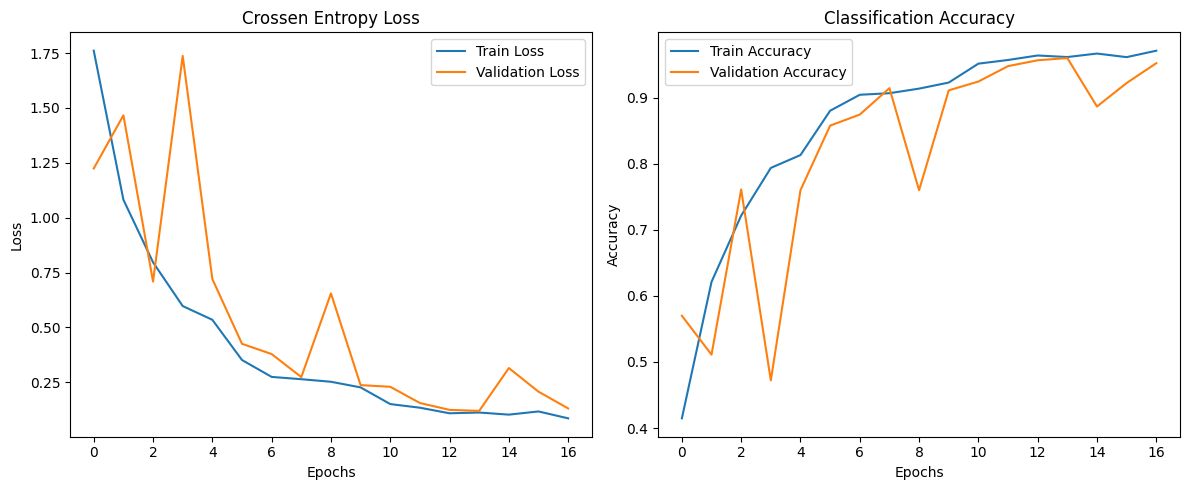

In [24]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Crossen Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis=1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 95.88888883590698
The Loss of the model for testing data is: 0.11430508643388748


In [26]:
labels = [i for i in os.listdir(image_dir) if '.' not in i]                    

print(classification_report(y_true, y_pred,target_names=labels))

                    precision    recall  f1-score   support

   Hourse Mackerel       0.97      0.98      0.98       100
   Black Sea Sprat       0.92      0.97      0.94       100
          Sea Bass       0.98      0.95      0.96       100
        Red Mullet       0.97      1.00      0.99       100
             Trout       0.95      0.97      0.96       100
Striped Red Mullet       0.94      0.92      0.93       100
            Shrimp       0.99      0.96      0.97       100
   Gilt-Head Bream       0.94      0.96      0.95       100
     Red Sea Bream       0.98      0.92      0.95       100

          accuracy                           0.96       900
         macro avg       0.96      0.96      0.96       900
      weighted avg       0.96      0.96      0.96       900



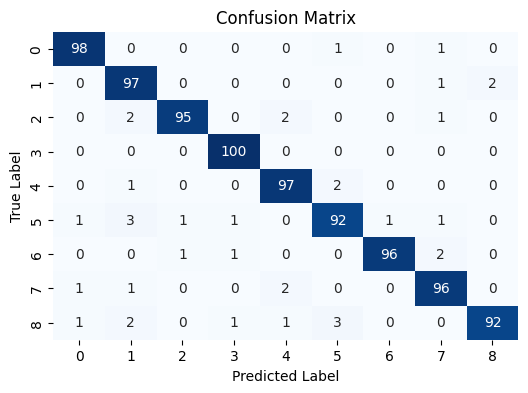

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model Correction Step

## Visualize images where our model was mistaken

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step


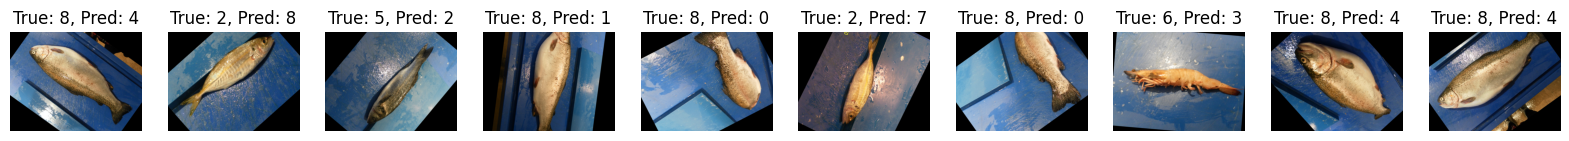

In [28]:
# Make predictions on the test set
predictions = model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_generator.classes

# Identify misclassified images
misclassified_indices = np.where(predicted_labels  != true_labels)[0]

# Visualize misclassified images
fig, axes = plt.subplots(1, 10, figsize=(20, 4))  # Adjust the number 10 as needed
for idx, ax in enumerate(axes):
    if idx >= len(misclassified_indices):
        break
    misclassified_idx = misclassified_indices[idx]
    image_path = val_generator.filepaths[misclassified_idx]
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f"True: {true_labels[misclassified_idx]}, Pred: {predicted_labels[misclassified_idx]}")
    ax.axis('off')
plt.show()

In [29]:
val_generator.class_indices

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}